## Building a Neural Network: Comparing TensorFlow and Keras

If we look at the post on building a neural net using first principles (without using neural net libraries), we can see the architecture of the network and the amount of code required build a simple model. This is a follow-up post on this topic.

This post is an illustration that compares tensorflow and keras coding styles for the very well researched problem of MNIST dataset. The key idea here is to illustrate the coding styles 

#### Note:
1> You must have both keras and tensorflow installed 

2> Internet connection required to download the dataset

### Recognizing handwritten digits with a Neural Net

One of the most common examples for neural net image classification is handwritten digit recognition from the MNIST dataset. The MNIST data set is a collection of 70,000 handwriting samples of the numbers 0-9. Our goal is to predict which number each handwritten image represents.

There are many neural network models that are specialized for dealing with image processing. The Convolutional Neural Network (CNN) architecture is the most popular and widely used system for processing predictions based on image data. For this basic task we do not require the use of CNNs and our basic neural network will do just fine.

The flattening process doesn't always have to result in 1D of 784 numbers array. As long as we're consistent in how we flatten each image into an array, it'll still work. Yes, it would be even better if we could preserve the 2D structure of the data while training

#### About the dataset:
The MNIST dataset is a collection of 70,000 images of handwritten digits provided in a greyscale 28 x 28 pixel format. The dataset is split into 55,000 for training, plus 5,000 validation set, and 10,000 test sets. Each image is 28x28 grayscale pixels, so we can treat each image as just a (flat) 1D array, or tensor, of (28 x 28 =) 784 numbers. This dataset is part of the tensorflow library.

#### Let's start with TensorFlow

In [32]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [33]:
sess = tf.InteractiveSession()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The test data is encoded as "one hot" when we loaded it. Think of one hot as a binary representation of the labels - that is, which number each handwriting sample was intended to represent. One hot represents a dimension for every possible label value. Every dimension is set to the value 0, except for the "correct" one which is set to 1. It's just a format that's optimized for how the labels are applied during training.

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


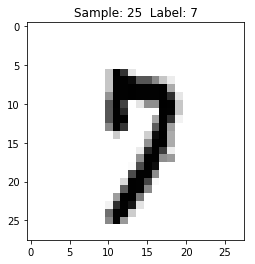

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(mnist.train.labels[num])  
    #Print the label converted back to a number
    label = mnist.train.labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = mnist.train.images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(25)

Pretty cool!! The above is the graphical display of number 7 sourced from the sample set number 25. Let's try out another example, this time let's select the last number in the sample set, which is 54999.

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


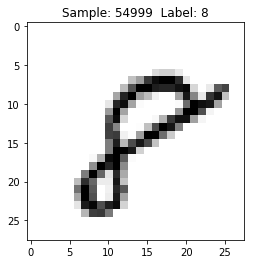

In [35]:
display_sample(54999)

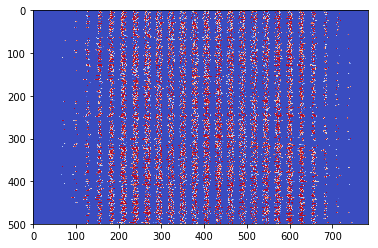

In [36]:
import numpy as np

images = mnist.train.images[0].reshape([1,784])
for i in range(1, 500):
    images = np.concatenate((images, mnist.train.images[i].reshape([1,784])))

plt.imshow(images, cmap=plt.get_cmap('coolwarm'))
plt.show()

We need to setup artificial neural network (ANN). Let's start by creating "placeholders" for the input images and for the "correct" labels for each. Think of these as parameters - we build up our neural network model without knowledge of the actual data that will be fed into it; we just need to construct it in such a way that our data will fit in.

So our "input_images" placeholder will be set up to hold an array of values that consist of 784 floats (28x28), and our "target_labels" placeholder will be set up to hold an array of values that consist of 10 floats (one-hot format for 10 digits.)

While training, we'll assign input_images to the training images and target_labels to the training lables. While testing, we'll use the test images and test labels instead.

In [37]:
input_images = tf.placeholder(tf.float32, shape=[None, 784])
target_labels = tf.placeholder(tf.float32, shape=[None, 10])

So let's set up our deep neural network. We'll need an input layer with one node per input pixel per image, or 784 nodes. That will feed into a hidden layer of some arbitrary size - let's pick 512. That hidden layer will output 10 values, corresonding to scores for each classification between 0 to 9 to be fed into softmax.

In [38]:
hidden_nodes = 512

input_weights = tf.Variable(tf.truncated_normal([784, hidden_nodes]))
input_biases = tf.Variable(tf.zeros([hidden_nodes]))

hidden_weights = tf.Variable(tf.truncated_normal([hidden_nodes, 10]))
hidden_biases = tf.Variable(tf.zeros([10]))

Let's define the input layer and connect it with our placeholder for input data. All this layer does is multiply these inputs by our input_weight tensor. The weight tensor will be learned over time.

Then we'll feed that into our hidden layer, which applies the ReLU activation function to the weighted inputs with our learned biases added in as well.

Finally our output layer, called digit_weights, multiplies in the learned weights of the hidden layer and adds in the hidden layer's bias term.

In [39]:
input_layer = tf.matmul(input_images, input_weights)
hidden_layer = tf.nn.relu(input_layer + input_biases)
digit_weights = tf.matmul(hidden_layer, hidden_weights) + hidden_biases

The above block sets up a deep neural network with different layers:

an input layer 

hidden layers

an output layer

In the next code line, let's define our loss function for use in measuring our progress in gradient descent: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications much more than ones that are close. 

In [40]:
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=digit_weights, labels=target_labels))

Let's set the learning rate at 0.5. The learning rate is an example of a hyperparameter that may be worth experimenting with and tuning.

In [41]:
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss_function)

Before we can train our network to make predictions, we need to define some methods for measuring the accuracy of our model.

In [42]:
correct_prediction = tf.equal(tf.argmax(digit_weights,1), tf.argmax(target_labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [43]:
%%time
tf.global_variables_initializer().run()

for x in range(3000):
    batch = mnist.train.next_batch(100)
    optimizer.run(feed_dict={input_images: batch[0], target_labels: batch[1]})
    if ((x+1) % 100 == 0):
        print("Training epoch " + str(x+1))
        print("Accuracy: " + str(accuracy.eval(feed_dict={input_images: mnist.test.images, target_labels: mnist.test.labels})))

Training epoch 100
Accuracy: 0.8588
Training epoch 200
Accuracy: 0.883
Training epoch 300
Accuracy: 0.8847
Training epoch 400
Accuracy: 0.8942
Training epoch 500
Accuracy: 0.9028
Training epoch 600
Accuracy: 0.9066
Training epoch 700
Accuracy: 0.9115
Training epoch 800
Accuracy: 0.9131
Training epoch 900
Accuracy: 0.9153
Training epoch 1000
Accuracy: 0.9171
Training epoch 1100
Accuracy: 0.9143
Training epoch 1200
Accuracy: 0.9233
Training epoch 1300
Accuracy: 0.9212
Training epoch 1400
Accuracy: 0.929
Training epoch 1500
Accuracy: 0.9237
Training epoch 1600
Accuracy: 0.9279
Training epoch 1700
Accuracy: 0.9301
Training epoch 1800
Accuracy: 0.931
Training epoch 1900
Accuracy: 0.9318
Training epoch 2000
Accuracy: 0.9313
Training epoch 2100
Accuracy: 0.933
Training epoch 2200
Accuracy: 0.9333
Training epoch 2300
Accuracy: 0.9329
Training epoch 2400
Accuracy: 0.9319
Training epoch 2500
Accuracy: 0.9351
Training epoch 2600
Accuracy: 0.9367
Training epoch 2700
Accuracy: 0.9357
Training epoch

We have about 93% accuracy, which is not too bad on the base model! Let's check out the first 200 test images and look at the ones that are misclassified:

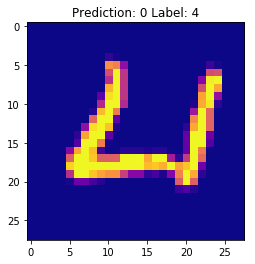

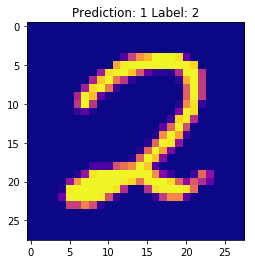

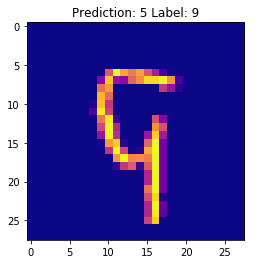

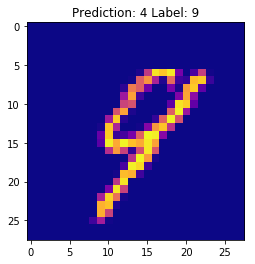

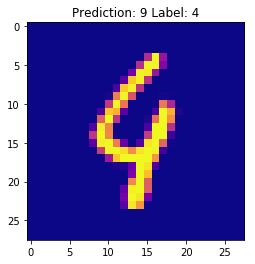

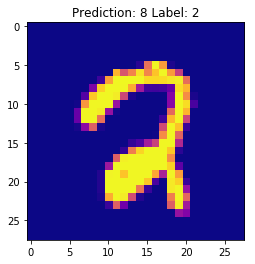

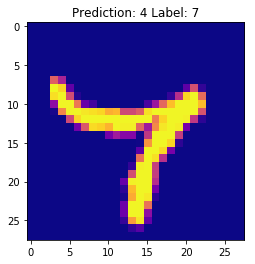

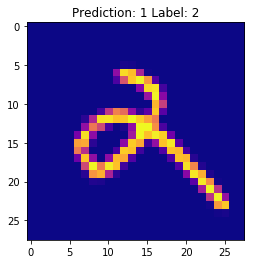

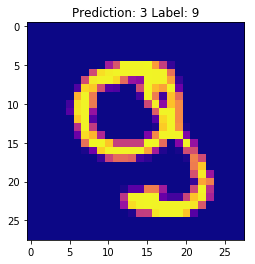

In [44]:
for x in range(200):
    # Load a single test image and its label
    x_train = mnist.test.images[x,:].reshape(1,784)
    y_train = mnist.test.labels[x,:]
    # Convert the one-hot label to an integer
    label = y_train.argmax()
    # Get the classification from our neural network's digit_weights final layer, and convert it to an integer
    prediction = sess.run(digit_weights, feed_dict={input_images: x_train}).argmax()
    # If the prediction does not match the correct label, display it
    if (prediction != label) :
        plt.title('Prediction: %d Label: %d' % (prediction, label))
        plt.imshow(x_train.reshape([28,28]), cmap=plt.get_cmap('plasma'))
        plt.show()

Can't say I blame the network, even my brain would be confused with some these digits! Especially that "4" which was predicted to be a 9, and that "9" which was predicted to be a 4! 

## Tackling the MNIST dataset with Keras

Keras makes it easier to model and build neural networks with a number of neural net frameworks. As on date Keras works with TensorFlow, Theano, and CNTK backends. The library also comes with a number of datasets that have been put to good use in machine learning courses and it's widespread use gives us a benchmark to compare our model performance. 

In [14]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [15]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

In [16]:
train_images = mnist_train_images.reshape(60000, 784)
test_images = mnist_test_images.reshape(10000, 784)
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [17]:
train_labels = keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = keras.utils.to_categorical(mnist_test_labels, 10)

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


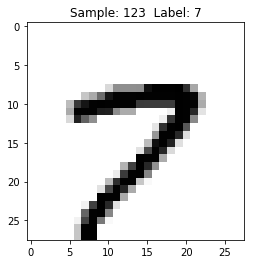

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = train_images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(123)

In [19]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [22]:
%%time
history = model.fit(train_images, train_labels,
                    batch_size=200,
                    epochs=20,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 6s - loss: 0.2902 - acc: 0.9169 - val_loss: 0.1503 - val_acc: 0.9554
Epoch 2/20
 - 6s - loss: 0.1189 - acc: 0.9655 - val_loss: 0.1074 - val_acc: 0.9683
Epoch 3/20
 - 6s - loss: 0.0777 - acc: 0.9772 - val_loss: 0.0755 - val_acc: 0.9773
Epoch 4/20
 - 6s - loss: 0.0566 - acc: 0.9830 - val_loss: 0.0701 - val_acc: 0.9780
Epoch 5/20
 - 6s - loss: 0.0430 - acc: 0.9875 - val_loss: 0.0669 - val_acc: 0.9797
Epoch 6/20
 - 6s - loss: 0.0331 - acc: 0.9906 - val_loss: 0.0613 - val_acc: 0.9811
Epoch 7/20
 - 6s - loss: 0.0255 - acc: 0.9926 - val_loss: 0.0621 - val_acc: 0.9816
Epoch 8/20
 - 6s - loss: 0.0199 - acc: 0.9944 - val_loss: 0.0625 - val_acc: 0.9810
Epoch 9/20
 - 6s - loss: 0.0157 - acc: 0.9957 - val_loss: 0.0616 - val_acc: 0.9831
Epoch 10/20
 - 6s - loss: 0.0120 - acc: 0.9969 - val_loss: 0.0629 - val_acc: 0.9827
Epoch 11/20
 - 6s - loss: 0.0093 - acc: 0.9977 - val_loss: 0.0641 - val_acc: 0.9818
Epoch 12/20
 - 6s - loss: 0.0072 - 

In [23]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0863671189512
Test accuracy: 0.9829


Looks like we've improved accuracy from 93% to 98%! That's a very good improvement (but to be fair, it's a fairly well-defined, simple dataset) without trying too hard. 

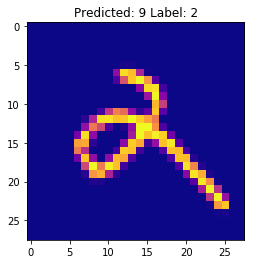

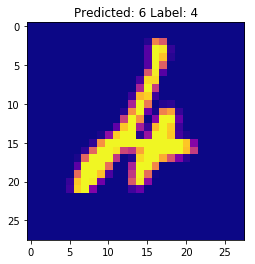

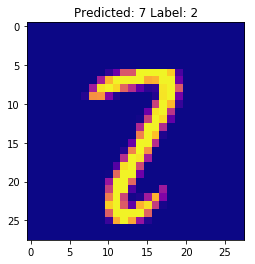

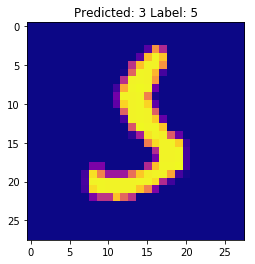

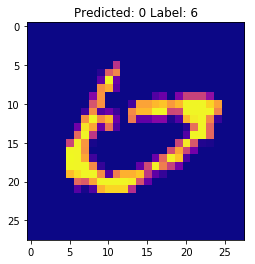

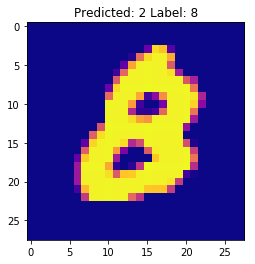

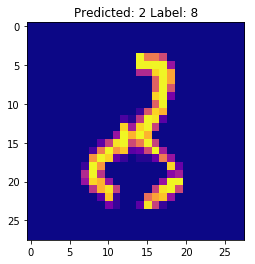

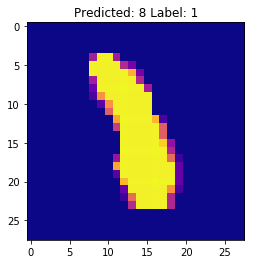

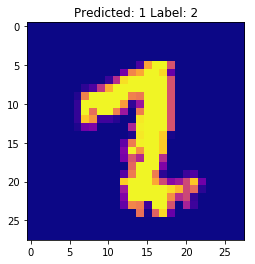

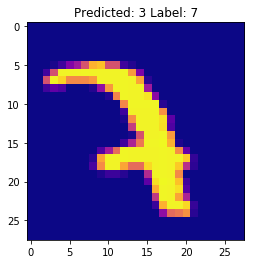

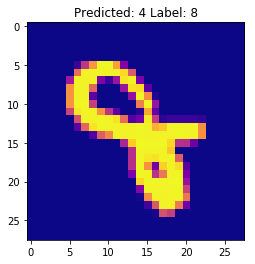

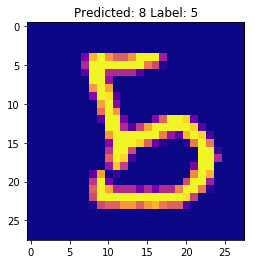

In [24]:
for x in range(750):
    test_image = test_images[x,:].reshape(1,784)
    predicted_cat = model.predict(test_image).argmax()
    label = test_labels[x].argmax()
    if (predicted_cat != label):
        plt.title('Predicted: %d Label: %d' % (predicted_cat, label))
        plt.imshow(test_image.reshape([28,28]), cmap=plt.get_cmap('plasma'))
        plt.show()

### Let's try to build a better model

In [25]:
model2 = Sequential()
model2.add(Dense(512, activation='relu', input_shape=(784,)))
model2.add(Dropout(0.25))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(10, activation='softmax'))

In [26]:
model2.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [27]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [28]:
%%time
history = model2.fit(train_images, train_labels,
                    batch_size=200,
                    epochs=20,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 11s - loss: 0.2812 - acc: 0.9138 - val_loss: 0.1250 - val_acc: 0.9608
Epoch 2/20
 - 10s - loss: 0.1136 - acc: 0.9651 - val_loss: 0.0842 - val_acc: 0.9736
Epoch 3/20
 - 10s - loss: 0.0818 - acc: 0.9747 - val_loss: 0.0729 - val_acc: 0.9781
Epoch 4/20
 - 10s - loss: 0.0631 - acc: 0.9804 - val_loss: 0.0818 - val_acc: 0.9760
Epoch 5/20
 - 10s - loss: 0.0543 - acc: 0.9830 - val_loss: 0.0722 - val_acc: 0.9788
Epoch 6/20
 - 10s - loss: 0.0469 - acc: 0.9855 - val_loss: 0.0710 - val_acc: 0.9809
Epoch 7/20
 - 11s - loss: 0.0414 - acc: 0.9877 - val_loss: 0.0738 - val_acc: 0.9805
Epoch 8/20
 - 11s - loss: 0.0354 - acc: 0.9896 - val_loss: 0.0771 - val_acc: 0.9814
Epoch 9/20
 - 11s - loss: 0.0327 - acc: 0.9901 - val_loss: 0.0776 - val_acc: 0.9827
Epoch 10/20
 - 11s - loss: 0.0292 - acc: 0.9909 - val_loss: 0.0810 - val_acc: 0.9825
Epoch 11/20
 - 11s - loss: 0.0254 - acc: 0.9924 - val_loss: 0.0869 - val_acc: 0.9820
Epoch 12/20
 - 12s - los

In [29]:
score = model2.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0939312825696
Test accuracy: 0.9841


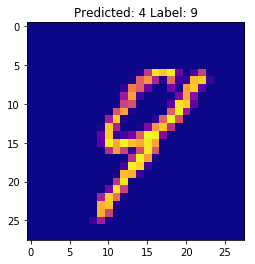

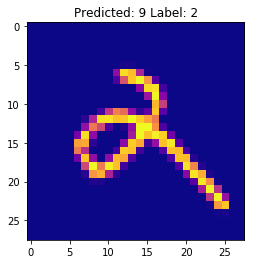

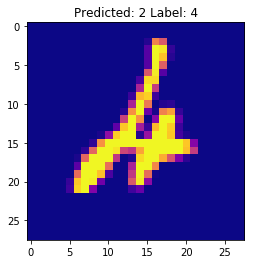

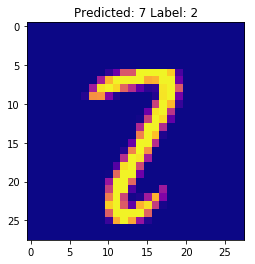

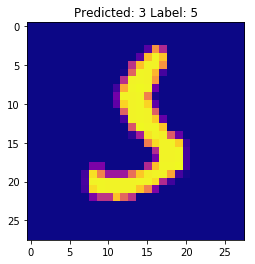

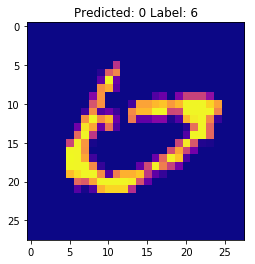

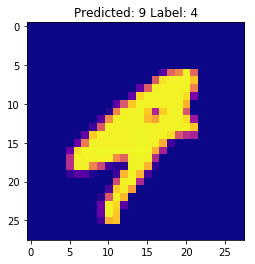

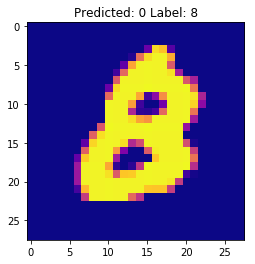

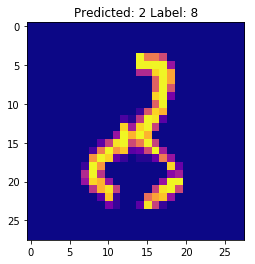

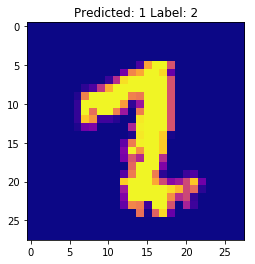

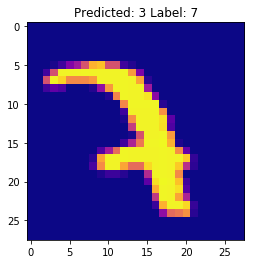

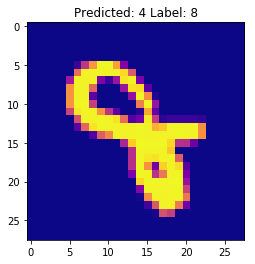

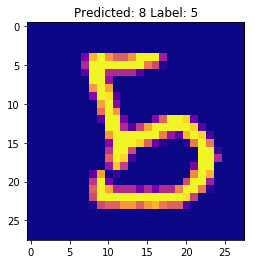

In [30]:
for x in range(750):
    test_image = test_images[x,:].reshape(1,784)
    predicted_cat = model2.predict(test_image).argmax()
    label = test_labels[x].argmax()
    if (predicted_cat != label):
        plt.title('Predicted: %d Label: %d' % (predicted_cat, label))
        plt.imshow(test_image.reshape([28,28]), cmap=plt.get_cmap('plasma'))
        plt.show()